In [1]:
import torch
import matplotlib.pyplot as plt
import os
import imageio
import datasets.toy_datasets as datasets
import utils.sde_lib as SDEs
from utils.models import MatrixTimeEmbedding, MLP
from utils.model_utils import get_preconditioned_model
from utils.metrics import get_w2

torch.set_printoptions(precision=4,sci_mode=False)

In [2]:
# SB 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = f'./checkpoints/vdsm/itr_100000'
# model_path = f'./checkpoints/board-momentum/itr_11000'
forward_score  = MatrixTimeEmbedding([2]).to(device)
mom_score = MLP(2,False).to(device)
forward_score.load_state_dict(torch.load(os.path.join(model_path,'forward_ema.pt')))
mom_score.load_state_dict(torch.load(os.path.join(model_path,'backward_ema.pt')))


linear_momentum = SDEs.LinearSchrodingerBridge(forward_model=forward_score, backward_model=mom_score)

print(forward_score.Lambda)

Parameter containing:
tensor([ 0.0362, -0.0026], device='cuda:0', requires_grad=True)


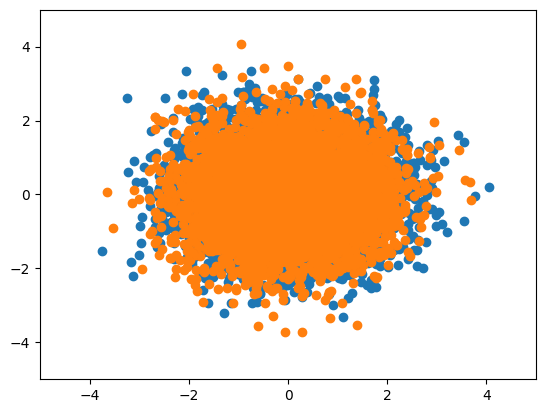

In [3]:

noise_shift = linear_momentum.prior_sampling((5000,2),device)
noise = torch.randn_like(noise_shift)

plt.scatter(noise_shift[:,0].cpu().detach(), noise_shift[:,1].cpu().detach())
plt.scatter(noise[:,0].cpu().detach(), noise[:,1].cpu().detach())
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [4]:
# SB 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = f'./checkpoints/momentum/itr_30000'
# model_path = f'./checkpoints/board-momentum/itr_11000'
forward_score  = MatrixTimeEmbedding([4]).to(device)
mom_score = MLP(2,True).to(device)
forward_score.load_state_dict(torch.load(os.path.join(model_path,'forward_ema.pt')))
mom_score.load_state_dict(torch.load(os.path.join(model_path,'backward_ema.pt')))


linear_momentum = SDEs.LinearMomentumSchrodingerBridge(forward_model=forward_score, backward_model=mom_score)

cld_score = MLP(2,True).to(device)
cld_score.load_state_dict(torch.load('checkpoints/cld/itr_30000/backward_ema.pt'))
cld = SDEs.CLD()
cld_score = get_preconditioned_model(cld_score, cld)
cld.backward_score = cld_score

print(forward_score.Lambda)

Parameter containing:
tensor([-0.0080, -0.0014,  0.0129,  0.0093], device='cuda:0',
       requires_grad=True)


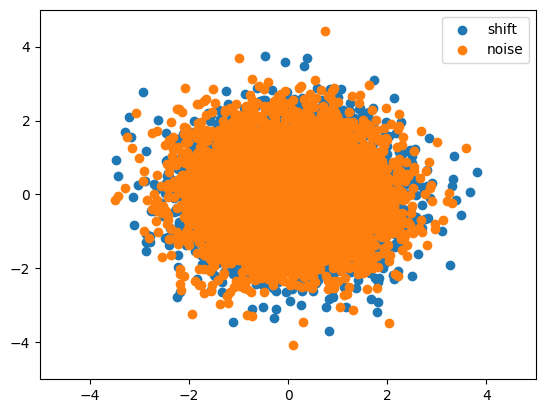

In [12]:

noise_shift = linear_momentum.prior_sampling((5000,4),device)
noise = torch.randn_like(noise_shift)

plt.scatter(noise_shift[:,0].cpu().detach(), noise_shift[:,1].cpu().detach(), label='shift')
plt.scatter(noise[:,0].cpu().detach(), noise[:,1].cpu().detach(), label='noise')
# plt.scatter(noise_shift[:,2].cpu().detach(), noise_shift[:,3].cpu().detach(),label='shift')
# plt.scatter(noise[:,2].cpu().detach(), noise[:,3].cpu().detach(), label='noise')
plt.legend()
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()

In [44]:
dataset = datasets.Spiral(x_scalar=0.4, y_scalar=3.2,batch_size=5000)
true = next(iter(dataset)).to(device)
mom_samp, _ = linear_momentum.sample((5000,4),device, n_time_pts=12)
cld_samp, _ = cld.sample((5000,4),device, n_time_pts=12)

print(get_w2(true,mom_samp[:,:2]))
print(get_w2(true,cld_samp[:,:2]))


tensor(2.840, device='cuda:0')
tensor(3.819, device='cuda:0')


In [24]:
def plot_trajectories(traj, save_path, gif_name='trajectories.gif'):
    idx = range(traj.shape[1])
    file_names = [os.path.join(save_path,f'{i}.png') for i in idx]
    dt = 1/(traj.shape[1]-1)
    plt.figure(figsize=(8, 8))  # Increase the figure size for better readability
    
    for i in idx:
        plt.clf()
        plt.title(f't = {dt * i : .2f}')
        plt.grid(zorder=0)
        plt.scatter(traj[:,i,0].detach().cpu(), traj[:,i,1].detach().cpu())
        # plt.xlim(traj[:,-1:,0].cpu().min()-0.5, traj[:,-1:,0].cpu().max()+0.5)
        # plt.ylim(traj[:,-1:,1].cpu().min()-0.5, traj[:,-1:,1].cpu().max()+0.5)
        plt.xlim(-5,10)
        plt.ylim(-22, 41)

        plt.savefig(file_names[i])
    plt.clf()
    with imageio.get_writer(gif_name, mode='I', duration=0.05) as writer:
        for filename in file_names:
            image = imageio.imread(filename)
            writer.append_data(image)

    # Optional: Clean up the temporary files
    # for filename in file_names:
    #     os.remove(filename)

def plot_lines(traj, filename):
    plt.clf()
    plt.figure(figsize=(8, 8))  # Increase the figure size for better readability

    # Add grid, labels, and title
    plt.grid(True, linestyle='--', linewidth=0.5)
    for i in range(traj.shape[0]):
        xi = traj[i]
        plt.plot(xi[:,0].cpu(), xi[:,1].cpu(), linewidth=1, alpha=.3)

    # plt.scatter(traj[:,0,0].cpu(), traj[:,0,1].cpu(), label='start',zorder=1010, cmap='viridis', s=10, alpha=0.75)
    plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
    # plt.xlim(traj[:,-1:,0].cpu().min()-0.5, traj[:,-1:,0].cpu().max()+0.5)
    # plt.ylim(traj[:,-1:,1].cpu().min()-0.5, traj[:,-1:,1].cpu().max()+0.5)
    plt.xlim(-5,10)
    plt.ylim(-22, 41)

    plt.legend()
    plt.savefig(filename,facecolor='none', edgecolor='none', transparent=True)

In [48]:
def create_all_figs(sde : SDEs.SDE,type):
    n_samples = 1000
    true_samples = dataset.__next__(n_samples * 5)
    samples, traj = sde.sample((n_samples,4),device,prob_flow=False,return_traj=True,n_time_pts=25)
    # cld_samp, traj_cld = sdes[1].sample((n_samples,4),device,prob_flow=False, return_traj=True, n_time_pts=25)
    # Create the plot
    plt.figure(figsize=(8, 8))  # Increase the figure size for better readability
    plt.scatter(true_samples[:,0].cpu(), true_samples[:,1].cpu(), s=10, alpha=0.75,label='true')  # Use colormap, adjust size and transparency
    # plt.scatter(cld_samp[:,0].cpu(), cld_samp[:,1].cpu(), s=10, alpha=0.75, label='cld')  # Use colormap, adjust size and transparency
    plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), s=10, alpha=0.75, label='generated')  # Use colormap, adjust size and transparency

    # Add grid, labels, and title
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Adjust the axis limits if needed
    plt.xlim(-5,10)
    plt.ylim(-22, 41)
    # plt.xlim(samples[:,0].cpu().min()-0.5, samples[:,0].cpu().max()+0.5)
    # plt.ylim(samples[:,1].cpu().min()-0.5, samples[:,1].cpu().max()+0.5)
    plt.legend()
    # Show the plot
    plt.show()

    plot_lines(traj, f'trajectory/lines_{type}.png')
    plot_trajectories(traj,save_path=f'./trajectory/{type}/',gif_name=f'trajectory/trajectories_board_{type}.gif')

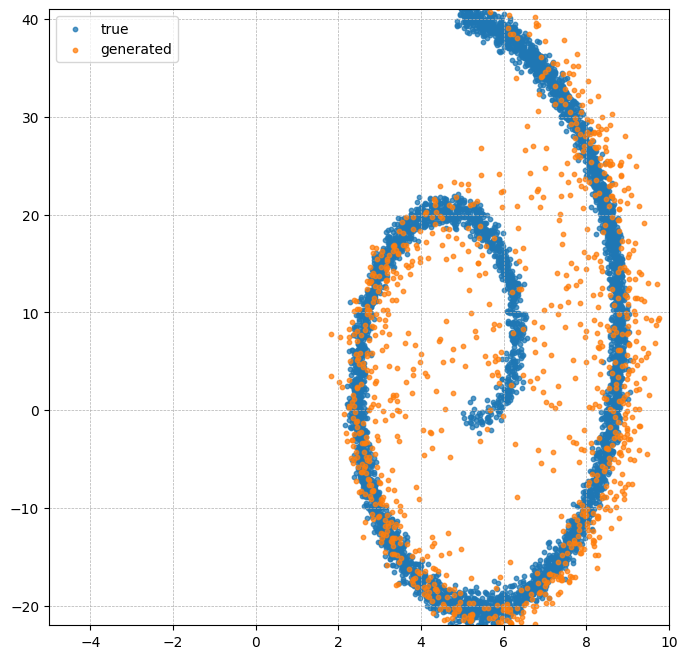

/tmp/ipykernel_50854/2621322435.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
/tmp/ipykernel_50854/2621322435.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 640x480 with 0 Axes>

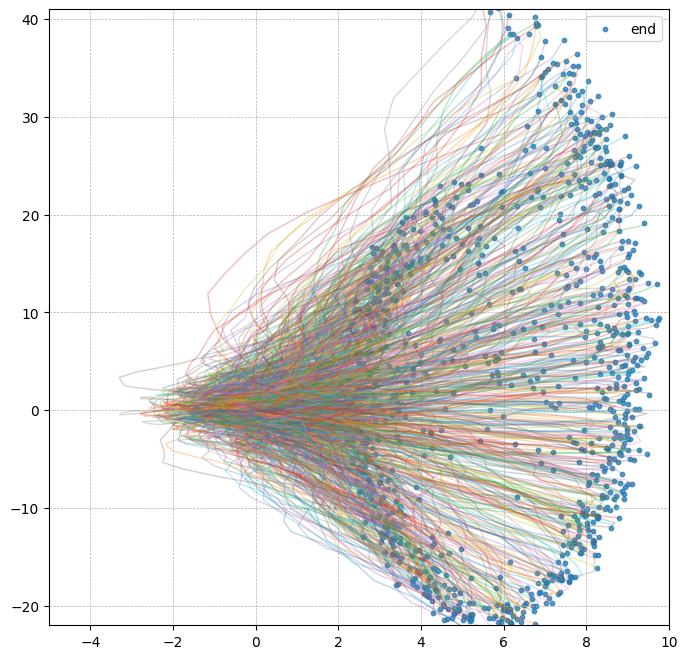

<Figure size 800x800 with 0 Axes>

In [49]:
create_all_figs(linear_momentum,'momentum')


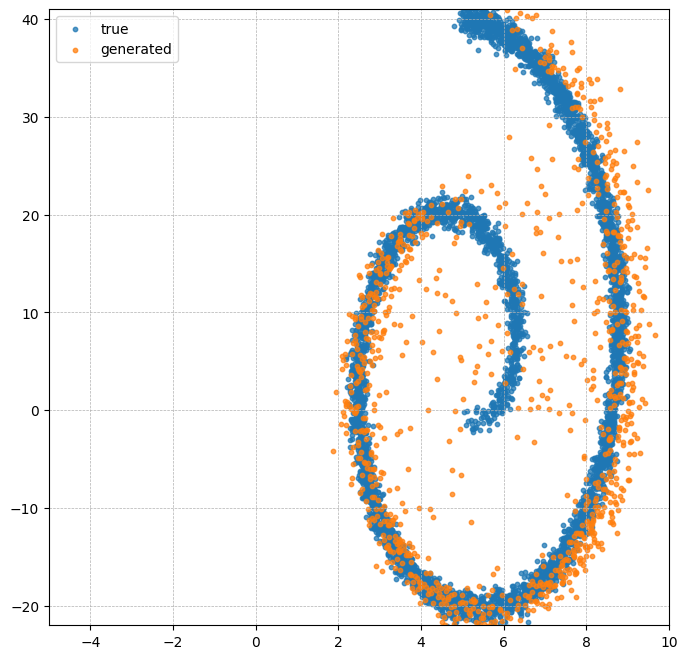

/tmp/ipykernel_50854/2621322435.py:39: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(traj[:,-1:,0].cpu(), traj[:,-1,1].cpu(),label='end', cmap='viridis', s=10, alpha=0.75)
/tmp/ipykernel_50854/2621322435.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


<Figure size 640x480 with 0 Axes>

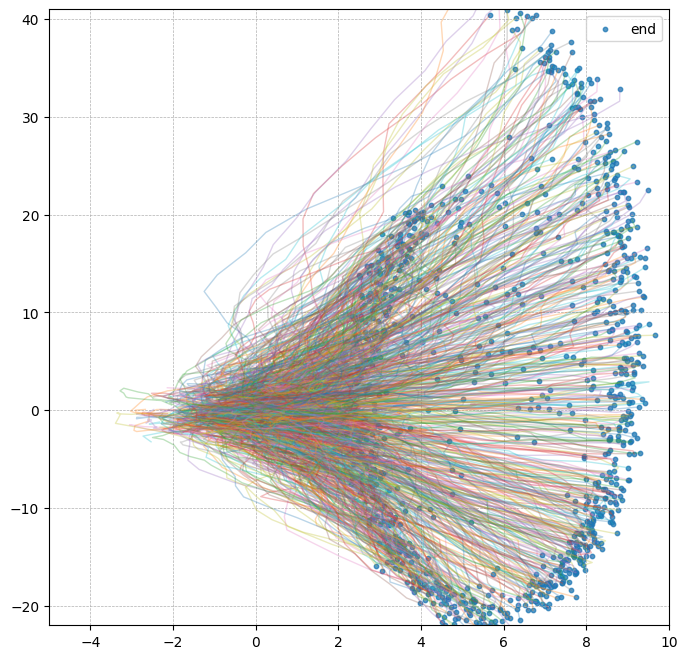

<Figure size 800x800 with 0 Axes>

In [50]:
create_all_figs(cld,'cld')

In [ ]:
n_pts = 20
x_pts = torch.linspace(-5,5,n_pts,device=device)#.view(-1,1)
y_pts = torch.linspace(-27,32,n_pts, device=device)#.view(-1,1)
x_pts, y_pts = torch.meshgrid((x_pts,y_pts))
x_pts = x_pts.reshape(-1,1)
y_pts = y_pts.reshape(-1,1)
z_pts = torch.cat((x_pts,y_pts),dim=-1)
n_time = 100
times = torch.linspace(0,1,n_time,device=device).unsqueeze(-1)
dt = 1/n_time
xt = dataset.sample(1000).to(device=device)
noise = torch.randn_like(xt)
for i,t in enumerate(times):
    t_shape = t.expand(z_pts.shape[0]).unsqueeze(-1)
    
    vector_field = sde.probability_flow_drift(z_pts,t_shape)
    plt.xlim(-27,32)
    plt.ylim(-27,32)
    plt.quiver(x_pts.cpu(),y_pts.cpu(),vector_field[:,0].cpu(),vector_field[:,1].cpu())
    plt.scatter(xt[:,0].cpu(), xt[:,1].cpu(),alpha=.3)
    plt.scatter(noise[:,0].cpu(), noise[:,1].cpu(),alpha=.1)
    plt.savefig(f'./vector-field/{i}.png')
    plt.clf()
    xt = xt + sde.probability_flow_drift(xt,t.expand(xt.shape[0]).unsqueeze(-1)) * dt


/home/kevin/anaconda3/envs/variational/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (400x3 and 5x128)

In [ ]:
import torch
from utils.models import MatrixTimeEmbedding

forward_score = MatrixTimeEmbedding([4])
forward_score.load_state_dict(torch.load('checkpoints/momentum/itr_30000/forward.pt'))

t = torch.linspace(.1,1.,5)

print(forward_score(t))

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<ReluBackward0>)


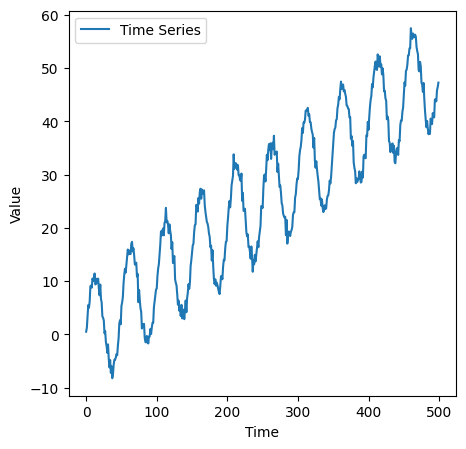

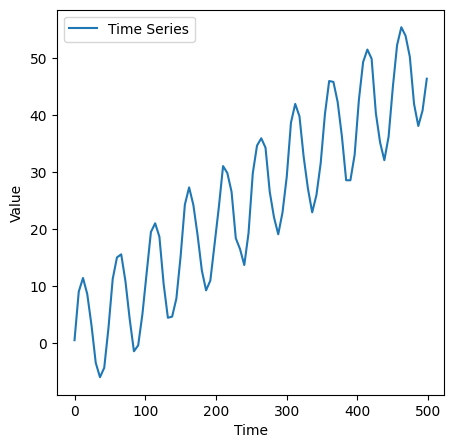

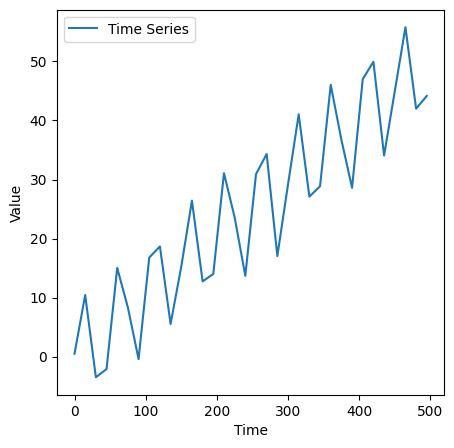

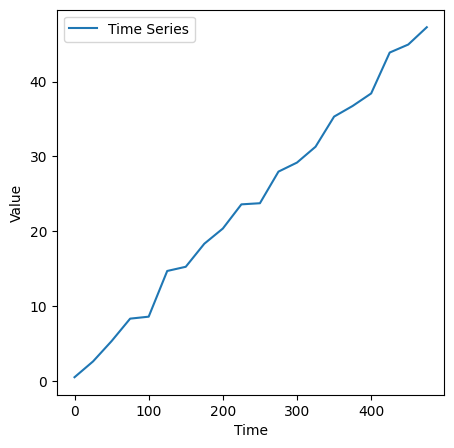

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(42)

# Parameters
n_points = 500
time = np.arange(n_points)

# Linear trend
trend = 0.1 * time

# Seasonal component
period = 50
seasonal = 10 * np.sin(2 * np.pi * time / period)

# Random noise
noise = np.random.normal(0, 1, n_points)

# Combine components to create the time series
time_series = trend + seasonal + noise

# Plot the time series
k = 25
for k in [1,6, 15, 25]:
    plt.figure(figsize=(5, 5))
    plt.clf()
    plt.plot(time[::k], time_series[::k], label='Time Series')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig(f'./{k}')
